In [9]:
%load_ext autoreload
%autoreload 2

import os

os.environ['HUGGINGFACE_HUB_CACHE'] = f'/scratch/{os.environ["USER"]}/huggingface_cache'
os.environ['OPENAI_API_KEY'] = open("key").read()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt

In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration

llava_model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-13b-hf").to('cuda')
llava_processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-13b-hf")

2024-03-31 17:01:11.633891: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-31 17:01:12.719054: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
def test_llava():
    # url = "https://www.ilankelman.org/stopsigns/australia.jpg"
    # image = Image.open(requests.get(url, stream=True).raw)
    image = Image.open("IMG_8400.png")
    prompt = """
    <image>
    USER: I want you to help me clean up. How could I start cleaning up in this scenario? Give me a very concrete / literal set of steps.
    First, write "Observations:" followed by some of your observations. Then, write "Plan:", followed by a very specific set of objects
    and actions to manipulate them.
    ASSISTANT: Observations:"""

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    inputs = llava_processor(text=prompt, images=image, return_tensors="pt").to('cuda')

    # Generate
    max_tokens = 384
    generate_ids = llava_model.generate(**inputs, max_new_tokens=384)
    generated = llava_processor.batch_decode(generate_ids[:, inputs.input_ids.shape[1]:], skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

    print("Suggested Steps.")
    print("Step 1." + generated)

    prompt_2 = f"""{prompt}{generated}
    USER: Now, give instructions to a robot to follow these steps. Write your answers in the format "Object: [object], Action: [action]".
    ASSISTANT: Code format for the plan I generated:
    1."""

    inputs = llava_processor(text=prompt_2, images=image, return_tensors="pt").to('cuda')

    # Generate
    generate_ids = llava_model.generate(**inputs, max_new_tokens=384)
    generated_2 = llava_processor.batch_decode(generate_ids[:, inputs.input_ids.shape[1]:], skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

    print("Objects to manipulate.")
    print("1. " + generated_2)


### Observations

Clearly, there are slight limitations in how accurate our vision model can be. However, in some cases we can probably just use GPT-4V. The next step is to generate a segmentation mask for affordance locations.

In [4]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPSegForImageSegmentation
import torchvision.transforms.functional as TF
import numpy as np

clipseg_processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to('cuda')

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def detect(image, Object, resize_output=True):
    inputs = clipseg_processor(text=[Object], images=[image], padding=True, return_tensors="pt").to('cuda')

    outputs = clipseg_model(**inputs)

    # Resize.
    width = image.width
    height = image.height
    
    if resize_output:
        logits = TF.resize(outputs.logits.unsqueeze(0), (height, width)).squeeze(0)
        
    logits = TF.resize(outputs.logits.unsqueeze(0), (height, width)).squeeze(0)
    logits = logits.detach().cpu().numpy()
    
    return logits

# Overlay this with the image.
# plt.title("Detected Object")
# plt.imshow(image)
# detection = detect(image, 'laptop')
# plt.imshow(detection, alpha=sigmoid(detection))
# plt.axis('off')
# plt.show()

2024-03-31 17:03:03.047798: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-31 17:03:04.161209: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/sfs/weka/scratch/gsk6me/WORLDMODELS/rvt/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/sfs/weka/scratch/gsk6me/WORLDMODELS/rvt/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Putting This Together

Let's make a quick loop.


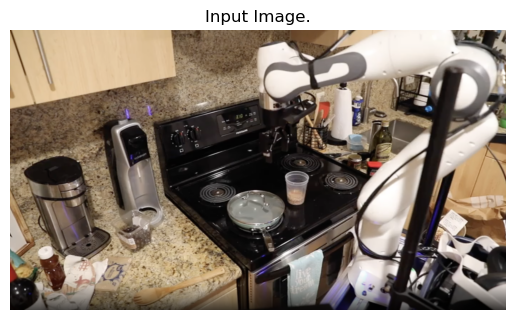

>>>>>>>>>> Raw GPT-4V Response
Observations: In the image, there is a stove with a pan on top of one of the burners. To the right of the stove, there is a clear bottle that appears to contain oil. To the left of the stove, there is a robotic arm, which is presumably what needs to be instructed to carry out the task. There are various other items on the countertop, but they are not relevant for pouring oil into the pan.

Plan:
1. Object: Clear oil bottle, Action: Grasp bottle firmly
2. Object: Clear oil bottle, Action: Lift bottle from countertop
3. Object: Clear oil bottle, Action: Position bottle over the center of the pan
4. Object: Clear oil bottle, Action: Tilt bottle to pour oil
5. Object: Clear oil bottle, Action: Return bottle to upright position to stop pouring
6. Object: Clear oil bottle, Action: Place bottle back on countertop
7. Object: Robot arm, Action: Move away from stove area
<<<<<<<<<< Raw GPT-4V Response
>>>>>>>>>> Parsed Observations Section
Observations: In the imag

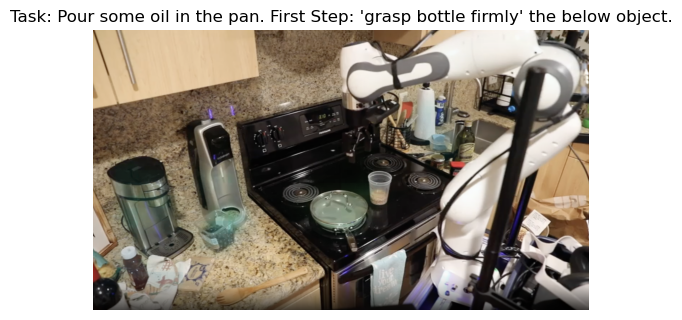

In [17]:
import re
import io
import base64

def llava(image, text, max_new_tokens=384):
    prompt = f"<image>{text}"
    inputs = llava_processor(text=prompt, images=image, return_tensors="pt").to('cuda')
    
    generate_ids = llava_model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated = llava_processor.batch_decode(
        generate_ids[:, inputs.input_ids.shape[1]:],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )[0]
    
    return generated

def pil_image_to_base64(image):
    """
    Convert a PIL Image to base64 format.

    Args:
    - image (PIL Image): Input image.

    Returns:
    - str: Base64 representation of the image.
    """
    # Convert the PIL Image to bytes
    img_byte_array = io.BytesIO()
    image.save(img_byte_array, format='PNG')
    img_byte_array = img_byte_array.getvalue()

    # Convert the bytes to base64
    base64_image = base64.b64encode(img_byte_array).decode('utf-8')
    return base64_image

def scale_image(image, max_dim=1024):
    """
    Resize the image so that the maximum dimension is `max_dim`.
    
    Args:
    - image (PIL Image): Input image
    - max_dim (int): Maximum dimension (width or height) of the output image
    
    Returns:
    - PIL Image: Resized image
    """
    width, height = image.size
    if max(width, height) > max_dim:
        if width > height:
            new_width = max_dim
            new_height = int(max_dim * height / width)
        else:
            new_height = max_dim
            new_width = int(max_dim * width / height)
        image = image.resize((new_width, new_height), Image.BICUBIC)
    return image

def gpt4v(image, text, max_new_tokens=384):
    from openai import OpenAI

    client = OpenAI()
    
    base64_image = pil_image_to_base64(image)

    response = client.chat.completions.create(
      model="gpt-4-vision-preview",
      messages=[
        {
          "role": "user",
          "content": [
            {"type": "text", "text": text},
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image}"
                }
            },
          ],
        }
      ],
      max_tokens=max_new_tokens,
    )
    
    return response.choices[0].message.content

def parse_plan(plan):
    # Extract the first bulleted list.
    lines = plan.strip().split("\n")
    steps = []
    for line in lines:
        # $ = end of line
        pattern = re.compile(fr"(\d+)\. Object: (.+?), Action: (.+?)$")
        match = pattern.match(line)
        if match is None:
            break
            
        # counter = int(match.group(1))
        object_ = match.group(2)
        action = match.group(3)
        
        steps.append((action, object_))
        
    return steps

def block(title, s):
    print((">" * 10), title)
    print(s)
    print(("<" * 10), title)

def generate_action_candidates(image, task, vlm='gpt4v'):
    plt.title("Input Image.")
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    # Simple prompt engineering.
    if vlm == 'llava':
        prompt = f"""
USER: {task}. How could I start doing this? Give me a very concrete / literal set of steps.
First, write "Observations:" followed by some of your observations. Then, write "Plan:", followed by a very specific set of objects
and actions to manipulate them.
ASSISTANT: Observations:"""
        
        reasoning = "Observations: " + vlm(image, prompt)
    
        block("Reasoning Generated By LLaVA", reasoning)
        
        prompt_2 = f"""{prompt}{reasoning}
        USER: Now, give instructions to a robot to follow these steps. Write your answers in the format "Object: [object], Action: [action]".
        ASSISTANT: 1. Object:"""
        plan_str = ("1. Object: " if vlm == llava else '') + vlm(image, prompt_2).strip()
        
        block("Parsed Plan Section", plan_str)
    else:
        prompt = f"""{task}. Given this image, how could I start doing this?e
Give me a very concrete / literal set of steps, as if you were instructing a robot
with very little semantic understanding, who can only use visual or physical descriptions
of how to interact with objects.

Begin your response with "Observations:" followed by some of your observations. Use this time to understand
the layout of the scene and what you could do to complete the task at hand.

Then, write "Plan:", followed by very concrete, literal action descriptions, of the format "Object: [object], Action: [action]".
Begin your answer with the string "1. ", and continue with a numbered list of the actions to take. Notes:
 - "Object" should be a text description of what object the robot should interact with in the scene. It should not refer to the robot arm itself.
 - "Action" should refer to the action the robot arm should take with the object.
 - Both "Object" and "Action" should be very brief descriptions (i.e. 3-5 words).
 - Ensure you adhere to the format "Object: [object], Action: [action]". The two text descriptions must be on the same line, separated by a comma.
""".strip()
        
        # response = gpt4v(image, prompt)
        response = """
Observations: In the image, there is a stove with a pan on top of one of the burners. To the right of the stove, there is a clear bottle that appears to contain oil. To the left of the stove, there is a robotic arm, which is presumably what needs to be instructed to carry out the task. There are various other items on the countertop, but they are not relevant for pouring oil into the pan.

Plan:
1. Object: Clear oil bottle, Action: Grasp bottle firmly
2. Object: Clear oil bottle, Action: Lift bottle from countertop
3. Object: Clear oil bottle, Action: Position bottle over the center of the pan
4. Object: Clear oil bottle, Action: Tilt bottle to pour oil
5. Object: Clear oil bottle, Action: Return bottle to upright position to stop pouring
6. Object: Clear oil bottle, Action: Place bottle back on countertop
7. Object: Robot arm, Action: Move away from stove area
        """.strip()
        
        block("Raw GPT-4V Response", response)
        
        plan_start_index = response.index("Plan:")
        observations = response[:plan_start_index]
        
        block("Parsed Observations Section", response)
        
        plan_str = response[plan_start_index + 5:].strip()
        
        block("Parsed Plan Section", plan_str)
    
    plan = parse_plan(plan_str)
    
    if len(plan) == 0:
        print("ERROR: Plan parsing failed.")
        return
    
    block("Parsed Action Literals", '\n'.join(str(x) for x in plan))
    
    # First step.
    action, object_ = plan[0]
    
    image = image.convert("RGB")
    detection = detect(image, object_)
    
    # Overlay this with the image.
    plt.title(f"Task: {task}. First Step: '{action.lower()}' the below object.")
    plt.imshow(image)
    plt.imshow(detect(image, 'laptop'), alpha=sigmoid(detection))
    plt.axis('off')
    plt.show()

if False:
    parse_plan("""
1. Object: Laptop, Action: Close
2. Object: Laptop, Action: Put in backpack
3. Object: Backpack, Action: Remove from floor
4. Object: Backpack, Action: Place on chair
5. Object: Laptop, Action: Open
6. Object: Laptop, Action: Put in backpack
7. Object: Backpack, Action: Remove from chair
8. Object: Backpack, Action: Place on floor
9. Object: Laptop, Action: Close
10. Object: Laptop, Action: Put in backpack
""")

image = scale_image(Image.open("droid_sample.png").convert("RGB"))
generate_action_candidates(image, "Pour some oil in the pan", vlm='gpt4v')
